In [1]:
# NSGA-II two-error-metric optimization

In [1]:
import sys, os, glob, pickle, toml, json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax


sys.path.append('/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src')
import NSGA2

# load data and calculate rank

In [2]:
outfile = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LSE_spaceCV_PredictParam/spaceCV_iter0_iter1_eval.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    rank_sse_iter0=dtmp['rank_sse_iter0']
    rank_lse_iter0=dtmp['rank_lse_iter0']
    rank_sse_iter1=dtmp['rank_sse_iter1']
    rank_lse_iter1=dtmp['rank_lse_iter1']
    met_iter0 = dtmp['met_iter0']
    met_sse_iter1=dtmp['met_sse_iter1']
    met_lse_iter1=dtmp['met_lse_iter1']

else:

    rank_sse_iter0 = np.nan * np.zeros([627, 400])
    rank_lse_iter0 = np.nan * np.zeros([627, 400])
    rank_sse_iter1 = np.nan * np.zeros([627, 40])
    rank_lse_iter1 = np.nan * np.zeros([627, 40])
    met_iter0 = np.nan * np.zeros([627, 400, 2])
    met_sse_iter1 = np.nan * np.zeros([627, 40, 2])
    met_lse_iter1 = np.nan * np.zeros([627, 40, 2])
    
    
    for b in range (627):

        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs_LSEall2err/iter0_many_metric.csv'
        met_iter0[b,:,:] = pd.read_csv(file)[['mae', 'max_mon_abs_err']].values
    
        # met_sse_iter1 = []
        # file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs_norm2err/iter1_many_metric.csv'
        # met_sse_iter1 = pd.read_csv(file)[['mae', 'max_mon_abs_err']].values
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs/iter1_all_metric.csv'
        met_sse_iter1[b, :, :] = pd.read_csv(file).values
    
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs_LSEall2err/iter1_many_metric.csv'
        met_lse_iter1[b, :, :] = pd.read_csv(file)[['mae', 'max_mon_abs_err']].values
    
        
        dtmp = np.vstack([met_iter0[b,:,:], met_sse_iter1[b, :, :]])
        if np.any(np.isnan(dtmp)):
            print('nan warning', b)
            # break
        rank, dom = NSGA2.fast_non_dominated_sort(dtmp)
        rank[np.isnan(np.sum(dtmp,axis=1))]=np.nan
        rank_sse_iter0[b, :] = rank[:400]
        rank_sse_iter1[b, :] = rank[400:]
    
        dtmp = np.vstack([met_iter0[b,:,:], met_lse_iter1[b, :, :]])
        if np.any(np.isnan(dtmp)):
            print('nan warning', b)
            # break
        rank, dom = NSGA2.fast_non_dominated_sort(dtmp)
        rank[np.isnan(np.sum(dtmp,axis=1))]=np.nan
        rank_lse_iter0[b, :] = rank[:400]
        rank_lse_iter1[b, :] = rank[400:]
        
        # plt.figure()
        # plt.scatter(met_iter0[:,0], met_iter0[:,1], label='iter0')
        # plt.scatter(met_lse_iter1[:,0], met_lse_iter1[:,1], label='lse iter1')
        # plt.scatter(met_sse_iter1[:,0], met_sse_iter1[:,1], label='sse iter2')
        # plt.legend()
        # plt.show()
    
        # plt.figure()
        # plt.hist(rank_sse_iter1, alpha=0.5, label='sse iter1')
        # plt.hist(rank_lse_iter1, alpha=0.5, label='lse iter1')
        # plt.legend()
        # plt.show()

    np.savez_compressed(outfile, rank_sse_iter0=rank_sse_iter0, rank_lse_iter0=rank_lse_iter0, 
                        rank_sse_iter1=rank_sse_iter1, rank_lse_iter1=rank_lse_iter1, 
                        met_iter0 = met_iter0, met_sse_iter1=met_sse_iter1, met_lse_iter1=met_lse_iter1)

# Comparison plot

In [3]:
print(rank_lse_iter0.shape)
print(np.mean(np.nanmin(rank_lse_iter1,axis=1)))
print(np.mean(np.nanmin(rank_sse_iter1,axis=1)))
print(np.mean(rank_lse_iter0[:,0]))
print(np.mean(rank_sse_iter0[:,0]))

(627, 400)
0.4609250398724083
1.3413078149920254
24.261562998405104
23.339712918660286


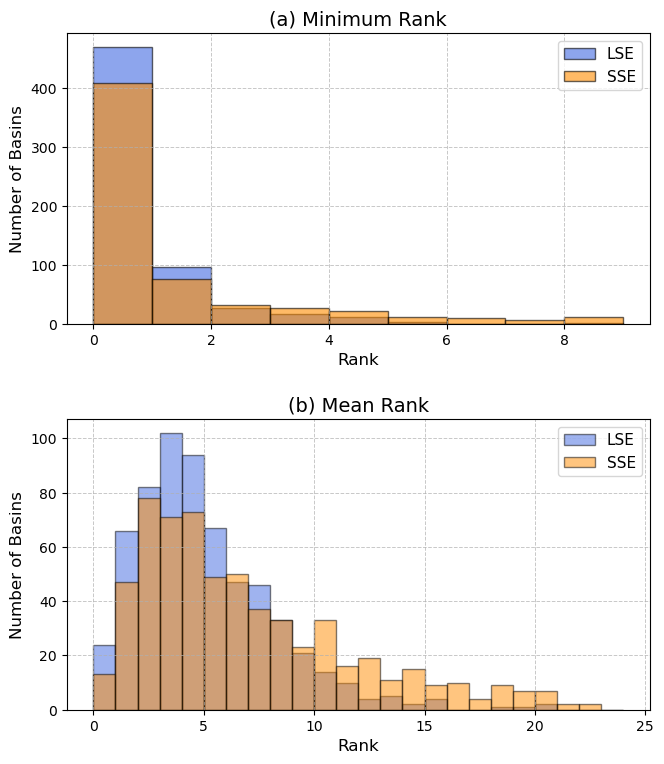

In [5]:
fig = plt.figure(figsize=[7, 8])  # Slightly larger figure for better readability

# First subplot: Minimum rank
ax1 = fig.add_subplot(2, 1, 1)
d1_min = np.nanmin(rank_lse_iter1, axis=1)
d2_min = np.nanmin(rank_sse_iter1, axis=1)

ax1.hist(d1_min, bins=np.arange(0, 10, 1), alpha=0.6, edgecolor='black', color='royalblue', label='LSE')
ax1.hist(d2_min, bins=np.arange(0, 10, 1), alpha=0.6, edgecolor='black', color='darkorange', label='SSE')

ax1.set_xlabel('Rank', fontsize=12)
ax1.set_ylabel('Number of Basins', fontsize=12)
ax1.set_title('(a) Minimum Rank', fontsize=14)
ax1.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax1.legend(fontsize=11)

# Second subplot: Mean rank
ax2 = fig.add_subplot(2, 1, 2)
d1_mean = np.nanmean(rank_lse_iter1, axis=1)
d2_mean = np.nanmean(rank_sse_iter1, axis=1)

ax2.hist(d1_mean, bins=np.arange(0, 25, 1), alpha=0.5, edgecolor='black', color='royalblue', label='LSE')
ax2.hist(d2_mean, bins=np.arange(0, 25, 1), alpha=0.5, edgecolor='black', color='darkorange', label='SSE')

ax2.set_xlabel('Rank', fontsize=12)
ax2.set_ylabel('Number of Basins', fontsize=12)
ax2.set_title('(b) Mean Rank', fontsize=14)
ax2.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax2.legend(fontsize=11)

# Optimize layout
plt.tight_layout(pad=2.0)
plt.savefig('LSE_SSE_ParetoRank_Iter1.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()